In [3]:
import os
import sys 
sys.path.insert(0, '/home/aiwenxu/2022-xu-retinal-degeneration')

**Phase 1/2 FI curve (injected current)**

In [2]:
from model.retinasim_phase12.simulation_fi import fi_curve_simulation
from model.retinasim_phase12.simulation_utils import SimulationParam
import pulse2percept as p2p
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
for light_g_max in [0.9]:
    for cone_population in [100, 60, 20]:

        sp_txt = "../model/parameter/cottaris_original_2hz.txt"
        sp = SimulationParam(sp_txt)
        sp.xy_coord_folder = "../model/layout_phase12/dendritic-tree-coordinate-{}".format(cone_population)
        sp.z_coord_folder = "../model/layout_phase12/z-coordinate-{}".format(cone_population)

        time_in_ms = 1200
        select_GPU = 1
        genn_directory = "GeNNworkspace_{}".format(select_GPU)
        pre_computed_weights_folder = "../model/weights_phase12"

        res_on = []
        res_off = []

        injected_currents = np.arange(0, 5, 0.1)
        
        save_folder = "../data/fig8/phase12_injected"
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        for cur_val in injected_currents:
            estim = p2p.stimuli.MonophasicPulse(-cur_val, 1000, stim_dur=1200, delay_dur=200)
            ic_ta_on = TimedArray(np.transpose(np.array([estim[0,::1][0] for i in range(719)])), dt=1*ms)
            ic_ta_off = TimedArray(np.transpose(np.array([estim[0,::1][0] for i in range(723)])), dt=1*ms)
            data = fi_curve_simulation(time_in_ms, sp, ic_ta_on, ic_ta_off, light_g_max, pre_computed_weights_folder, select_GPU=select_GPU, genn_directory=genn_directory)
            _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = data
            res_on.append([np.count_nonzero(spikes_gl_on['t'][k]>200*ms) for k in spikes_gl_on['t'].keys()])
            res_off.append([np.count_nonzero(spikes_gl_off['t'][k]>200*ms) for k in spikes_gl_off['t'].keys()])
            print("amp {} done".format(cur_val))

            res_on_np = np.array(res_on)
            res_off_np = np.array(res_off)

            np.save("{}/res_on_{}_{}.npy".format(save_folder, light_g_max, cone_population), res_on_np)
            np.save("{}/res_off_{}_{}.npy".format(save_folder, light_g_max, cone_population), res_off_np)

running brian code generation ...
building genn executable ...
['/home/aiwenxu/genn/bin/genn-buildmodel.sh', '-i', '/home/aiwenxu/2022-xu-retinal-degeneration/figures:/home/aiwenxu/2022-xu-retinal-degeneration/figures/GeNNworkspace_1:/home/aiwenxu/2022-xu-retinal-degeneration/figures/GeNNworkspace_1/brianlib/randomkit', 'magicnetwork_model.cpp']


Text(0.5, 1.0, 'OFF RGC')

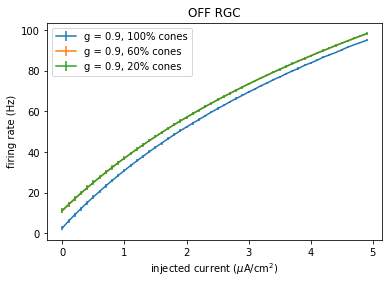

In [5]:
cell_type = "off"
for cp in [100, 60, 20]:
    for g in [0.9]:
        res = np.load("../data/fig8/phase12_injected/res_{}_{}_{}.npy".format(cell_type, g, cp))
        _ = plt.errorbar(np.arange(0, 5, 0.1), np.mean(res, axis=1), yerr=np.std(res, axis=1), label="g = {}, {}% cones".format(g, cp))
plt.legend()
plt.xlabel("injected current ($\mu$A/cm$^2$)")
plt.ylabel("firing rate (Hz)")
plt.title("OFF RGC")

Text(0.5, 1.0, 'ON RGC')

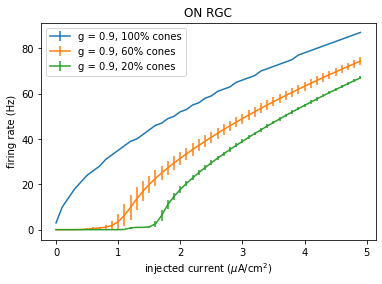

In [7]:
cell_type = "on"
for cp in [100, 60, 20]:
    for g in [0.9]:
        res = np.load("../data/fig8/phase12_injected/res_{}_{}_{}.npy".format(cell_type, g, cp))
        _ = plt.errorbar(np.arange(0, 5, 0.1), np.mean(res, axis=1), yerr=np.std(res, axis=1), label="g = {}, {}% cones".format(g, cp))
plt.legend()
plt.xlabel("injected current ($\mu$A/cm$^2$)")
plt.ylabel("firing rate (Hz)")
plt.title("ON RGC")

**Phase 1/2 FI curve (epiretinal)**

In [4]:
import numpy as np
from model.retinasim_phase12.simulation import estim_to_retina_output
from model.retinasim_phase12.simulation_utils import SimulationParam
import pickle
from brian2 import *
import pulse2percept as p2p

In [ ]:
pre_computed_weights_folder = "../model/weights_phase12"
implant_mode = "epiretinal"

for light_g_max in [0.9]:
    for cone_population in [100, 60, 20]:

        sp_txt = "../model/parameter/cottaris_original_2hz.txt"
        sp = SimulationParam(sp_txt)

        sp.xy_coord_folder = "../model/layout_phase12/dendritic-tree-coordinate-{}".format(cone_population)
        sp.z_coord_folder = "../model/layout_phase12/z-coordinate-{}".format(cone_population)
        sp.imped = 1000

        # subretinal stimulation
        if implant_mode == "subretinal":
            sp.implant_mode = "subretinal"
            sp.electrode_z = 135
            
        res_on = []
        res_off = []
            
        injected_currents = np.arange(0, 5, 0.1)
        
        data_folder = "../data/fig8/phase12_epiretinal"
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)

        for cur_val in injected_currents:
            estim = p2p.stimuli.MonophasicPulse(-cur_val, 1000, stim_dur=1200, delay_dur=200)

            time_in_ms = 1200
            select_GPU = 1
            genn_directory = "GeNNworkspace_{}".format(select_GPU)
            _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = estim_to_retina_output(time_in_ms, sp, light_g_max, estim, pre_computed_weights_folder, delta_ve_folder="delta_ve_workspace_{}".format(select_GPU), dt=0.1, select_GPU=select_GPU, genn_directory=genn_directory)
            res_on.append([np.count_nonzero(spikes_gl_on['t'][k]>200*ms) for k in range(len(spikes_gl_on['t'].keys()))])
            res_off.append([np.count_nonzero(spikes_gl_off['t'][k]>200*ms) for k in range(len(spikes_gl_off['t'].keys()))])
            print("amp {} done".format(cur_val))

            res_on_np = np.array(res_on)
            res_off_np = np.array(res_off)

            np.save("{}/res_on_{}_{}.npy".format(data_folder, light_g_max, cone_population), res_on_np)
            np.save("{}/res_off_{}_{}.npy".format(data_folder, light_g_max, cone_population), res_off_np)

In [7]:
def calculate_mean_std_center(res, cell_type):
    center = []
    res = np.transpose(res)
    x, y = np.load("../model/layout_phase12/dendritic-tree-coordinate-100/GL_{}.npy".format(cell_type.upper()))
    for key in range(res.shape[0]):
        if np.sqrt(np.square(x[key]) + np.square(y[key])) <= 40:
            center.append(res[key])
    center = np.array(center)
    return np.mean(center, axis=0), np.std(center, axis=0)

Text(0.5, 1.0, 'OFF RGC')

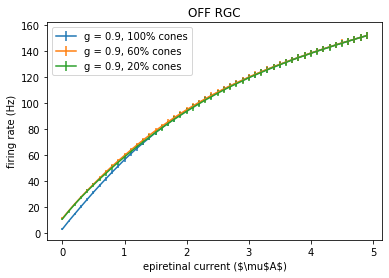

In [12]:
cell_type = "off"
for cp in [100, 60, 20]:
    for g in [0.9]:
        res = np.load("../data/fig8/phase12_epiretinal/res_{}_{}_{}.npy".format(cell_type, g, cp))
        mean, std = calculate_mean_std_center(res, "off")
        _ = plt.errorbar(np.arange(0, 5, 0.1), mean, yerr=std, label="g = {}, {}% cones".format(g, cp))
plt.legend()
plt.xlabel("epiretinal current ($\mu$A$)")
plt.ylabel("firing rate (Hz)")
plt.title("OFF RGC")

Text(0.5, 1.0, 'ON RGC')

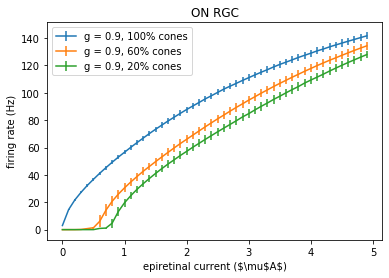

In [13]:
cell_type = "on"
for cp in [100, 60, 20]:
    for g in [0.9]:
        res = np.load("../data/fig8/phase12_epiretinal/res_{}_{}_{}.npy".format(cell_type, g, cp))
        mean, std = calculate_mean_std_center(res, "off")
        _ = plt.errorbar(np.arange(0, 5, 0.1), mean, yerr=std, label="g = {}, {}% cones".format(g, cp))
plt.legend()
plt.xlabel("epiretinal current ($\mu$A$)")
plt.ylabel("firing rate (Hz)")
plt.title("ON RGC")

**Phase 1/2 FI curve (subretinal)**

In [ ]:
pre_computed_weights_folder = "../model/weights_phase12"
implant_mode = "subretinal"

for light_g_max in [0.9]:
    for cone_population in [100, 60, 20]:

        sp_txt = "../model/parameter/cottaris_original_2hz.txt"
        sp = SimulationParam(sp_txt)

        sp.xy_coord_folder = "../model/layout_phase12/dendritic-tree-coordinate-{}".format(cone_population)
        sp.z_coord_folder = "../model/layout_phase12/z-coordinate-{}".format(cone_population)
        sp.imped = 1000

        # subretinal stimulation
        if implant_mode == "subretinal":
            sp.implant_mode = "subretinal"
            sp.electrode_z = 135
            
        res_on = []
        res_off = []
            
        injected_currents = np.arange(0, 5, 0.1)
        
        data_folder = "../data/fig8/phase12_subretinal"
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)

        for cur_val in injected_currents:
            estim = p2p.stimuli.MonophasicPulse(-cur_val, 1000, stim_dur=1200, delay_dur=200)

            time_in_ms = 1200
            select_GPU = 1
            genn_directory = "GeNNworkspace_{}".format(select_GPU)
            _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = estim_to_retina_output(time_in_ms, sp, light_g_max, estim, pre_computed_weights_folder, delta_ve_folder="delta_ve_workspace_{}".format(select_GPU), dt=0.1, select_GPU=select_GPU, genn_directory=genn_directory)
            res_on.append([np.count_nonzero(spikes_gl_on['t'][k]>200*ms) for k in range(len(spikes_gl_on['t'].keys()))])
            res_off.append([np.count_nonzero(spikes_gl_off['t'][k]>200*ms) for k in range(len(spikes_gl_off['t'].keys()))])
            print("amp {} done".format(cur_val))

            res_on_np = np.array(res_on)
            res_off_np = np.array(res_off)

            np.save("{}/res_on_{}_{}.npy".format(data_folder, light_g_max, cone_population), res_on_np)
            np.save("{}/res_off_{}_{}.npy".format(data_folder, light_g_max, cone_population), res_off_np)

Text(0.5, 1.0, 'OFF RGC')

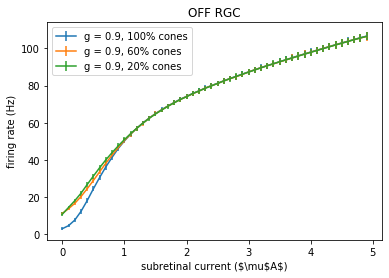

In [11]:
cell_type = "off"
for cp in [100, 60, 20]:
    for g in [0.9]:
        res = np.load("../data/fig8/phase12_subretinal/res_{}_{}_{}.npy".format(cell_type, g, cp))
        mean, std = calculate_mean_std_center(res, "off")
        _ = plt.errorbar(np.arange(0, 5, 0.1), mean, yerr=std, label="g = {}, {}% cones".format(g, cp))
plt.legend()
plt.xlabel("subretinal current ($\mu$A$)")
plt.ylabel("firing rate (Hz)")
plt.title("OFF RGC")

Text(0.5, 1.0, 'ON RGC')

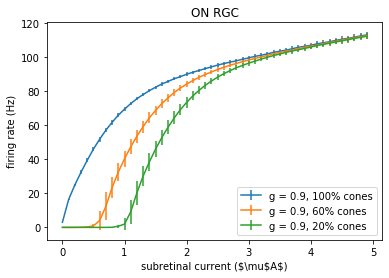

In [12]:
cell_type = "on"
for cp in [100, 60, 20]:
    for g in [0.9]:
        res = np.load("../data/fig8/phase12_subretinal/res_{}_{}_{}.npy".format(cell_type, g, cp))
        mean, std = calculate_mean_std_center(res, "off")
        _ = plt.errorbar(np.arange(0, 5, 0.1), mean, yerr=std, label="g = {}, {}% cones".format(g, cp))
plt.legend()
plt.xlabel("subretinal current ($\mu$A$)")
plt.ylabel("firing rate (Hz)")
plt.title("ON RGC")